# Salary Prediction Analysis

This notebook performs Exploratory Data Analysis (EDA) and builds linear regression models to predict salaries based on various features.

In [1]:
# Data Handling
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# Visualization
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For statistical visualizations

# Statistical Analysis 
import statsmodels.api as sm  # For statistical modeling and hypothesis testing
from statsmodels.stats.outliers_influence import variance_inflation_factor  # To detect multicollinearity
import scipy.stats as stats  # For statistical functions like hypothesis testing
from scipy.stats import f_oneway, pointbiserialr  # For ANOVA and correlation analysis

# Machine Learning 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  # For model training and evaluation
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # For feature scaling and encoding categorical variables
from sklearn.compose import ColumnTransformer  # To apply transformations to specific columns
from sklearn.pipeline import Pipeline  # To streamline preprocessing and model training
from sklearn.linear_model import LinearRegression, Ridge, Lasso  # For linear regression models
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error  # For model evaluation
from sklearn.decomposition import PCA  # For dimensionality reduction
from sklearn.feature_selection import SelectKBest, f_regression  # For feature selection

# Utility Functions 
import math  # For mathematical operations
import warnings  # To suppress warnings
warnings.filterwarnings('ignore')

# Plot Styling 
sns.set_palette('husl')  # Set color palette for plots


## 1. Data Loading and Initial Exploration

In [2]:
# Load the dataset
df = pd.read_csv('salaries.csv')

In [3]:
# Display basic information about the dataset
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88584 entries, 0 to 88583
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           88584 non-null  int64 
 1   experience_level    88584 non-null  object
 2   employment_type     88584 non-null  object
 3   job_title           88584 non-null  object
 4   salary              88584 non-null  int64 
 5   salary_currency     88584 non-null  object
 6   salary_in_usd       88584 non-null  int64 
 7   employee_residence  88584 non-null  object
 8   remote_ratio        88584 non-null  int64 
 9   company_location    88584 non-null  object
 10  company_size        88584 non-null  object
dtypes: int64(4), object(7)
memory usage: 7.4+ MB


In [4]:
print("\nFirst few rows:")
df.head(3)


First few rows:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,MI,FT,Customer Success Manager,57000,EUR,60000,NL,50,NL,L
1,2025,SE,FT,Engineer,165000,USD,165000,US,0,US,M
2,2025,SE,FT,Engineer,109000,USD,109000,US,0,US,M


In [5]:
print("\nBasic statistics:")
df.describe()


Basic statistics:


,work_year,salary,salary_in_usd,remote_ratio
count,88584.000000,8.858400e+04,88584.000000,88584.000000
mean,2024.034758,1.619323e+05,157567.798417,21.286011
std,0.620370,1.965317e+05,73531.373158,40.831018
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2024.000000,1.060000e+05,106097.250000,0.000000
50%,2024.000000,1.470000e+05,146307.000000,0.000000
75%,2024.000000,1.995000e+05,198600.000000,0.000000
max,2025.000000,3.040000e+07,800000.000000,100.000000


## 2. Data Preprocessing

In [6]:
# Automatically identify numerical and categorical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Define the target variable
target = 'salary_in_usd'

# Remove the target from the feature lists if present
if target in numerical_features:
    numerical_features.remove(target)
if target in categorical_features:
    categorical_features.remove(target)

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Checking correlation between categorical features and target variable
for cat in categorical_features:
    if df[cat].nunique() == 2:  # Binary categorical variable
        correlation, p_value = pointbiserialr(df[cat].astype('category').cat.codes, df[target])
        print(f"{cat}: Point-Biserial Correlation = {correlation:.4f}, p-value = {p_value:.4f}")
    else:  # Multi-category variable
        groups = [df[df[cat] == level][target] for level in df[cat].unique()]
        f_stat, p_value = f_oneway(*groups)
        print(f"{cat}: ANOVA F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")


experience_level: ANOVA F-statistic = 3372.6992, p-value = 0.0000
employment_type: ANOVA F-statistic = 160.7821, p-value = 0.0000
job_title: ANOVA F-statistic = 68.2016, p-value = 0.0000
salary_currency: ANOVA F-statistic = 243.0368, p-value = 0.0000
employee_residence: ANOVA F-statistic = 74.9501, p-value = 0.0000
company_location: ANOVA F-statistic = 78.8623, p-value = 0.0000
company_size: ANOVA F-statistic = 94.1076, p-value = 0.0000


Low p-values (< 0.05) indicate a significant relationship between the categorical feature and the target.

The **F-statistic** in an **ANOVA test** (Analysis of Variance) helps determine whether there are significant differences between the means of multiple groups for a given categorical variable. Here's how to interpret your results:

### **1. What does the F-statistic mean?**
- The **F-statistic** measures how much variance in the dependent variable (likely salary) can be explained by the independent categorical variable (e.g., experience level, job title).
- A **higher F-statistic** indicates a stronger relationship between the categorical variable and salary.

### **2. What does the p-value mean?**
- The **p-value** indicates whether the observed differences are statistically significant.
- A **p-value of 0.0000** (or very close to zero) suggests that the differences in salary across the groups of each categorical variable are **highly significant**.
- This means the categorical variable has a meaningful impact on salary.


**Experience level is the most important factor in determining salary** (highest F-statistic).  
**Other significant factors** include employment type, company size, location, and job title.  
**All variables are statistically significant** (p-value = 0.0000), meaning they all influence salary in a meaningful way.

In [8]:
# Checking Feature Importance

# Encode categorical variables
X_encoded = pd.get_dummies(df[categorical_features], drop_first=True)
X_final = pd.concat([df[numerical_features], X_encoded], axis=1)

# Select best features
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_final, df[target])

# Display feature scores
feature_scores = pd.DataFrame({"Feature": X_final.columns, "Score": selector.scores_})
print(feature_scores.sort_values(by="Score", ascending=False))



                                 Feature         Score
1                                 salary  11677.470613
343                  salary_currency_USD   5896.093011
5                    experience_level_SE   5826.012637
433                employee_residence_US   5690.627542
523                  company_location_US   5617.037589
..                                   ...           ...
142    job_title_Data Operations Manager      0.002805
261    job_title_Principal Data Engineer      0.001021
25        job_title_AI Software Engineer      0.000761
111            job_title_Data Governance      0.000695
241  job_title_Marketing Science Partner      0.000002

[531 rows x 2 columns]


In [9]:
# print the top 10 features
print("Top 10 Features:")
print(feature_scores.nlargest(20, "Score"))

Top 10 Features:
                                 Feature         Score
1                                 salary  11677.470613
343                  salary_currency_USD   5896.093011
5                    experience_level_SE   5826.012637
433                employee_residence_US   5690.627542
523                  company_location_US   5617.037589
97                job_title_Data Analyst   5065.162281
326                  salary_currency_EUR   2496.007323
327                  salary_currency_GBP   2454.081390
301          job_title_Software Engineer   2089.915673
218  job_title_Machine Learning Engineer   2049.433142
471                  company_location_GB   1993.044020
376                employee_residence_GB   1981.334570
4                    experience_level_MI   1592.841502
189        job_title_Engineering Manager    882.230503
33                     job_title_Analyst    808.678105
285         job_title_Research Scientist    761.337710
3                    experience_level_EX    643.

## 3. Exploratory Data Analysis (EDA)

In [10]:
def plot_numerical_distributions(df, numerical_features, target='salary_in_usd'):
    """
    Plot distributions of numerical features including the target variable
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    numerical_features (list): List of numerical feature names
    target (str): Name of the target variable
    """
    # Calculate number of features to plot (including target)
    features_to_plot = [target] + numerical_features
    n_features = len(features_to_plot)
    
    # Calculate optimal grid layout
    n_cols = 3  # You can adjust this
    n_rows = math.ceil(n_features / n_cols)
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    
    # Flatten axes array for easier indexing
    if n_rows > 1:
        axes = axes.flatten()
    
    # Create plots
    for i, col in enumerate(features_to_plot):
        if n_rows == 1:
            ax = axes[i] if n_features > 1 else axes
        else:
            ax = axes[i]
            
        # Create histogram with KDE
        sns.histplot(data=df, x=col, ax=ax, kde=True)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        
        # Format x-axis for large numbers
        if col == 'salary_in_usd':
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
            ax.tick_params(axis='x', rotation=45)
    
    # Remove empty subplots if any
    if n_rows > 1:
        for i in range(n_features, len(axes)):
            fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

# Function to add log-transformed plots
def plot_numerical_distributions_with_log(df, numerical_features, target='salary_in_usd'):
    """
    Plot both original and log-transformed distributions of numerical features
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    numerical_features (list): List of numerical feature names
    target (str): Name of the target variable
    """
    features_to_plot = [target] + numerical_features
    n_features = len(features_to_plot)
    
    # Create subplots (2 rows for each feature: original and log-transformed)
    fig, axes = plt.subplots(2, n_features, figsize=(5*n_features, 10))
    
    for i, col in enumerate(features_to_plot):
        # Original distribution
        sns.histplot(data=df, x=col, ax=axes[0, i], kde=True)
        axes[0, i].set_title(f'Distribution of {col}')
        axes[0, i].set_xlabel(col)
        
        # Log-transformed distribution
        # Add small constant to handle zeros
        log_data = np.log1p(df[col]) if col != 'remote_ratio' else df[col]
        sns.histplot(data=log_data, ax=axes[1, i], kde=True)
        axes[1, i].set_title(f'Log Distribution of {col}')
        axes[1, i].set_xlabel(f'log({col})')
        
        # Format x-axis for salary
        if col == 'salary_in_usd':
            axes[0, i].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
            axes[0, i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Function to create box plots
def plot_numerical_boxplots(df, numerical_features, target='salary_in_usd'):
    """
    Create box plots for numerical features
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    numerical_features (list): List of numerical feature names
    target (str): Name of the target variable
    """
    features_to_plot = [target] + numerical_features
    n_features = len(features_to_plot)
    
    fig, axes = plt.subplots(1, n_features, figsize=(5*n_features, 5))
    
    if n_features == 1:
        axes = [axes]
    
    for i, col in enumerate(features_to_plot):
        sns.boxplot(y=df[col], ax=axes[i])
        axes[i].set_title(f'Box Plot of {col}')
        
        # Format y-axis for salary
        if col == 'salary_in_usd':
            axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    plt.tight_layout()
    plt.show()

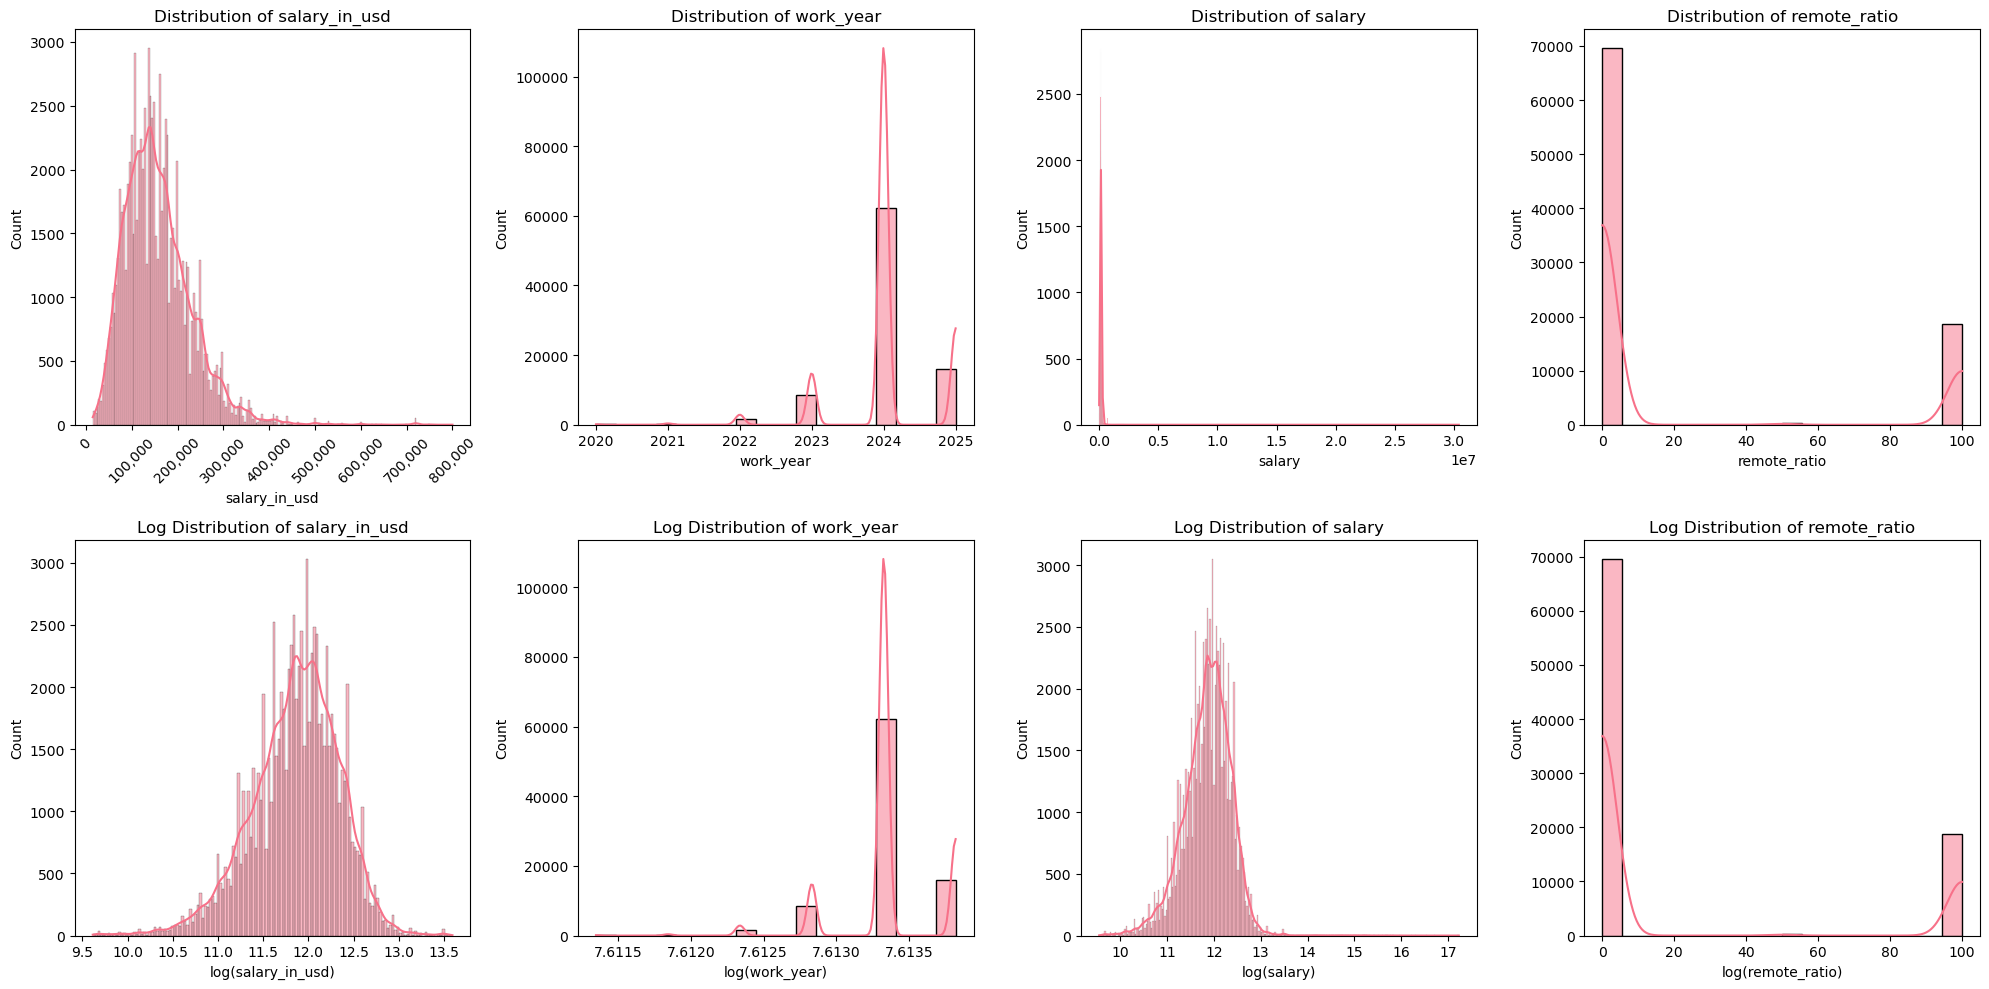

In [11]:
# Distribution plots with log transformation
plot_numerical_distributions_with_log(df, numerical_features)

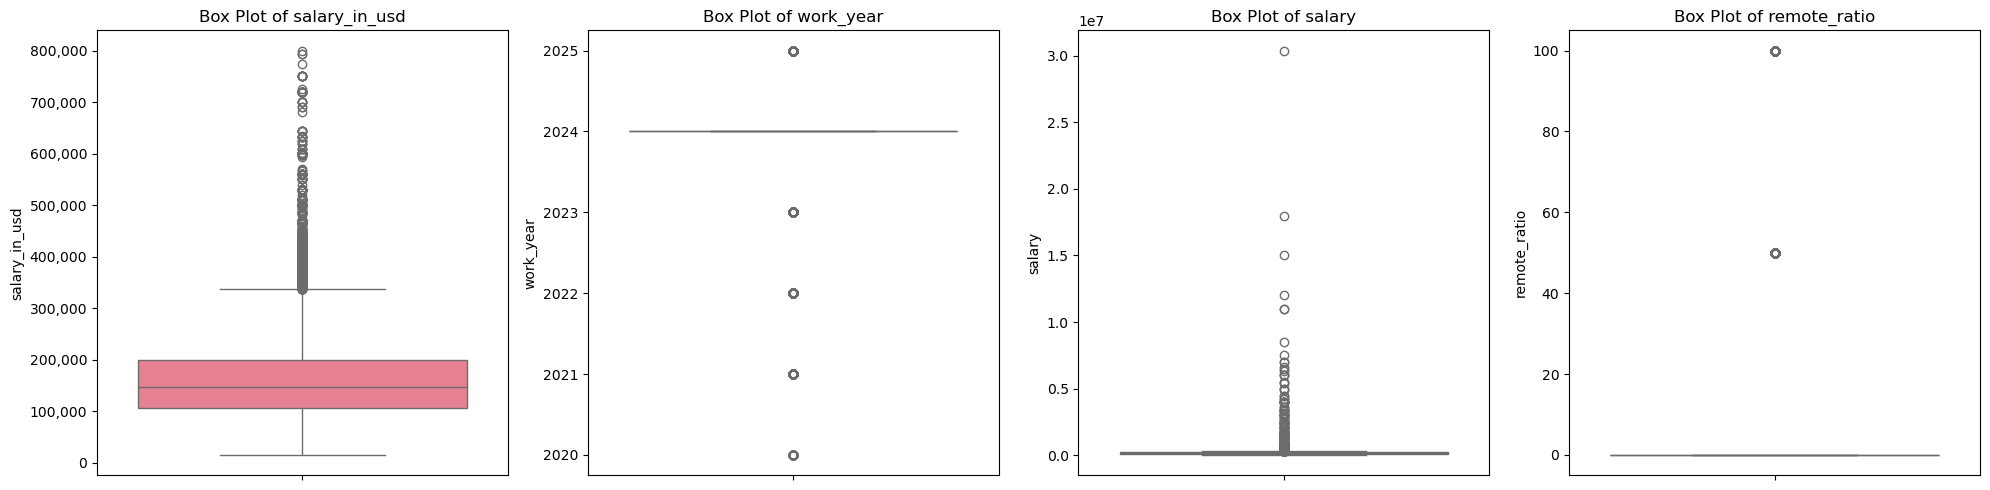

In [12]:
# Box plots
plot_numerical_boxplots(df, numerical_features)

In [13]:
def detect_outliers(df, numerical_features, target='salary_in_usd'):
    """
    Detect outliers using multiple methods:
    1. IQR (Interquartile Range) method
    2. Z-score method
    3. Modified Z-score method
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    numerical_features (list): List of numerical feature names
    target (str): Name of target variable
    """
    features_to_analyze = [target] + numerical_features
    
    # Dictionary to store results
    outlier_summary = {}
    
    for feature in features_to_analyze:
        # Get feature data
        data = df[feature]
        
        # 1. IQR Method
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        iqr_outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
        
        # 2. Z-score Method (threshold = 3)
        z_scores = np.abs(stats.zscore(data))
        z_score_outliers = (z_scores > 3).sum()
        
        # 3. Modified Z-score Method
        median = data.median()
        mad = stats.median_abs_deviation(data)
        modified_z_scores = 0.6745 * (data - median) / mad
        modified_z_score_outliers = (np.abs(modified_z_scores) > 3.5).sum()
        
        # Store results
        outlier_summary[feature] = {
            'IQR_method': iqr_outliers,
            'Z_score_method': z_score_outliers,
            'Modified_Z_score_method': modified_z_score_outliers,
            'Total_rows': len(data),
            'Percent_IQR': round(iqr_outliers / len(data) * 100, 2),
            'Percent_Z_score': round(z_score_outliers / len(data) * 100, 2),
            'Percent_Modified_Z': round(modified_z_score_outliers / len(data) * 100, 2)
        }
    
    # Convert to DataFrame for better display
    results_df = pd.DataFrame(outlier_summary).T
    
    return results_df

In [14]:
def print_outlier_summary(df, numerical_features, target='salary_in_usd'):
    """
    Print a formatted summary of outliers
    """
    results = detect_outliers(df, numerical_features, target)
    
    print("\n=== Outlier Detection Summary ===")
    print("\nNumber of outliers by different methods:")
    print("-" * 80)
    for feature in results.index:
        print(f"\nFeature: {feature}")
        print(f"Total observations: {results.loc[feature, 'Total_rows']}")
        print(f"IQR Method: {results.loc[feature, 'IQR_method']} outliers ({results.loc[feature, 'Percent_IQR']}%)")
        print(f"Z-score Method: {results.loc[feature, 'Z_score_method']} outliers ({results.loc[feature, 'Percent_Z_score']}%)")
        print(f"Modified Z-score Method: {results.loc[feature, 'Modified_Z_score_method']} outliers ({results.loc[feature, 'Percent_Modified_Z']}%)")
        print("-" * 80)
    
    return results


=== Outlier Detection Summary ===

Number of outliers by different methods:
--------------------------------------------------------------------------------

Feature: salary_in_usd
Total observations: 88584.0
IQR Method: 1750.0 outliers (1.98%)
Z-score Method: 870.0 outliers (0.98%)
Modified Z-score Method: 833.0 outliers (0.94%)
--------------------------------------------------------------------------------

Feature: work_year
Total observations: 88584.0
IQR Method: 26350.0 outliers (29.75%)
Z-score Method: 1953.0 outliers (2.2%)
Modified Z-score Method: 26350.0 outliers (29.75%)
--------------------------------------------------------------------------------

Feature: salary
Total observations: 88584.0
IQR Method: 1751.0 outliers (1.98%)
Z-score Method: 122.0 outliers (0.14%)
Modified Z-score Method: 962.0 outliers (1.09%)
--------------------------------------------------------------------------------

Feature: remote_ratio
Total observations: 88584.0
IQR Method: 19004.0 outliers 

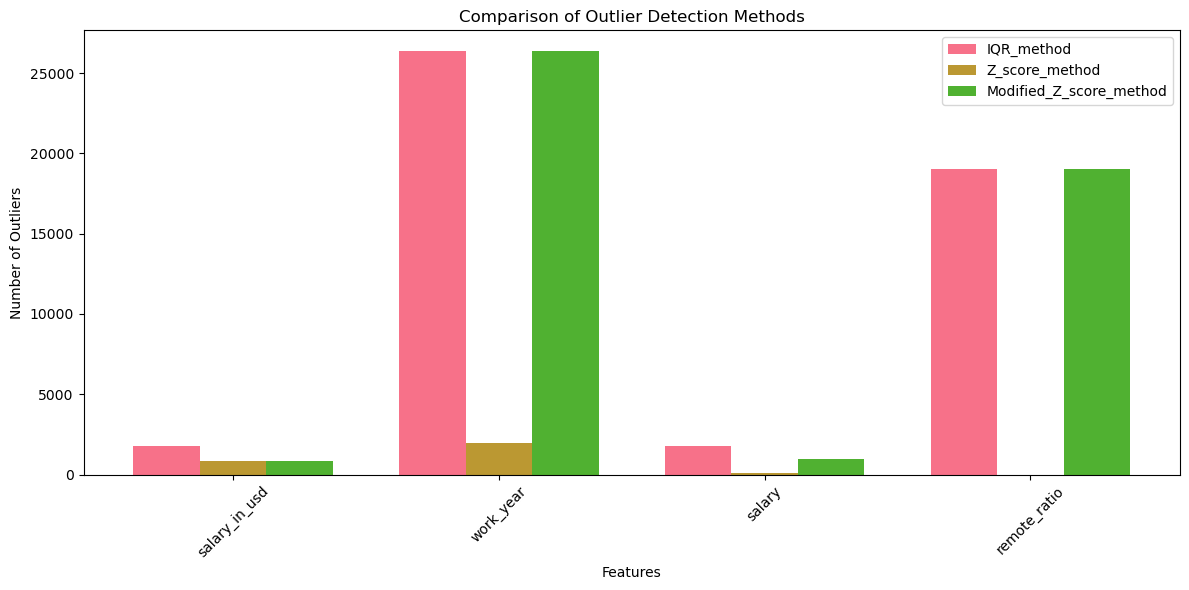

In [15]:
# Function to visualize outliers
def plot_outlier_comparison(df, numerical_features, target='salary_in_usd'):
    """
    Create a visual comparison of outliers detected by different methods
    """
    results = detect_outliers(df, numerical_features, target)
    
    # Prepare data for plotting
    methods = ['IQR_method', 'Z_score_method', 'Modified_Z_score_method']
    features = results.index
    
    # Create bar plot
    plt.figure(figsize=(12, 6))
    x = np.arange(len(features))
    width = 0.25
    
    for i, method in enumerate(methods):
        plt.bar(x + i*width, results[method], width, label=method)
    
    plt.xlabel('Features')
    plt.ylabel('Number of Outliers')
    plt.title('Comparison of Outlier Detection Methods')
    plt.xticks(x + width, features, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage example:
# Print detailed summary
results = print_outlier_summary(df, numerical_features)

# Plot visual comparison
plot_outlier_comparison(df, numerical_features)




In [16]:
def plot_categorical_distributions(df, categorical_features, figsize=(20, 15)):
    """
    Plot distributions of categorical features
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    categorical_features (list): List of categorical feature names
    figsize (tuple): Figure size
    """
    # Calculate optimal grid layout
    n_features = len(categorical_features)
    n_cols = 2  # You can adjust this
    n_rows = math.ceil(n_features / n_cols)
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Flatten axes array for easier indexing
    if n_rows > 1:
        axes = axes.flatten()
    
    # Create plots
    for i, col in enumerate(categorical_features):
        if n_rows == 1:
            ax = axes[i] if n_features > 1 else axes
        else:
            ax = axes[i]
            
        # Calculate value counts and percentages
        value_counts = df[col].value_counts()
        total = len(df[col])
        percentages = (value_counts / total * 100).round(1)
        
        # Create bar plot
        sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax)
        ax.set_title(f'Distribution of {col}')
        
        # Add percentage labels on top of each bar
        for j, p in enumerate(percentages):
            ax.text(j, value_counts[j], f'{p}%', ha='center', va='bottom')
        
        # Rotate x-axis labels if they're too long
        ax.tick_params(axis='x', rotation=45)
    
    # Remove empty subplots if any
    if n_rows > 1:
        for i in range(n_features, len(axes)):
            fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

def plot_categorical_vs_target(df, categorical_features, target='salary_in_usd', figsize=(20, 15)):
    """
    Plot relationship between categorical features and target variable
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    categorical_features (list): List of categorical feature names
    target (str): Name of target variable
    figsize (tuple): Figure size
    """
    n_features = len(categorical_features)
    n_cols = 2
    n_rows = math.ceil(n_features / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows > 1:
        axes = axes.flatten()
    
    for i, col in enumerate(categorical_features):
        if n_rows == 1:
            ax = axes[i] if n_features > 1 else axes
        else:
            ax = axes[i]
            
        # Create box plot
        sns.boxplot(x=col, y=target, data=df, ax=ax)
        ax.set_title(f'{col} vs {target}')
        ax.tick_params(axis='x', rotation=45)
        
        # Format y-axis for salary
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Remove empty subplots if any
    if n_rows > 1:
        for i in range(n_features, len(axes)):
            fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

def print_categorical_summary(df, categorical_features):
    """
    Print summary statistics for categorical features
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    categorical_features (list): List of categorical feature names
    """
    print("\n=== Categorical Features Summary ===\n")
    
    for col in categorical_features:
        value_counts = df[col].value_counts()
        unique_count = len(value_counts)
        total = len(df[col])
        
        print(f"\nFeature: {col}")
        print(f"Number of unique values: {unique_count}")
        print(f"Most common values (top 5):")
        
        # Print top 5 values with counts and percentages
        for val, count in value_counts.head().items():
            percentage = (count / total * 100).round(2)
            print(f"  {val}: {count} ({percentage}%)")
        
        # Check for missing values
        missing = df[col].isnull().sum()
        if missing > 0:
            missing_pct = (missing / total * 100).round(2)
            print(f"Missing values: {missing} ({missing_pct}%)")
        
        print("-" * 50)

def plot_categorical_correlation(df, categorical_features, figsize=(12, 8)):
    """
    Plot correlation between categorical features using Cramer's V
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    categorical_features (list): List of categorical feature names
    figsize (tuple): Figure size
    """
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2 = stats.chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        min_dim = min(confusion_matrix.shape) - 1
        return np.sqrt(chi2 / (n * min_dim))
    
    # Calculate Cramer's V for each pair of categorical variables
    n_features = len(categorical_features)
    cramer_matrix = np.zeros((n_features, n_features))
    
    for i in range(n_features):
        for j in range(n_features):
            if i != j:
                cramer_matrix[i, j] = cramers_v(
                    df[categorical_features[i]], 
                    df[categorical_features[j]]
                )
    
    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        cramer_matrix,
        annot=True,
        xticklabels=categorical_features,
        yticklabels=categorical_features,
        cmap='YlOrRd'
    )
    plt.title("Categorical Features Correlation (Cramer's V)")
    plt.tight_layout()
    plt.show()


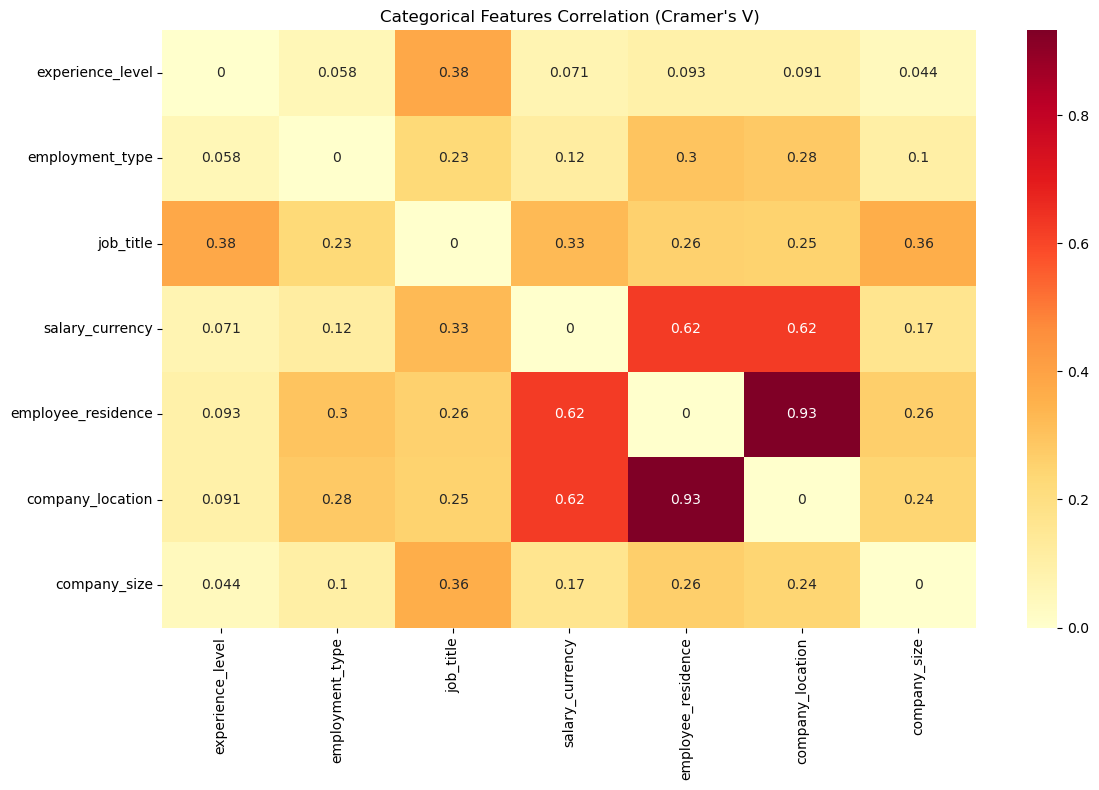

In [17]:
# Plot correlation between categorical features
plot_categorical_correlation(df, categorical_features)

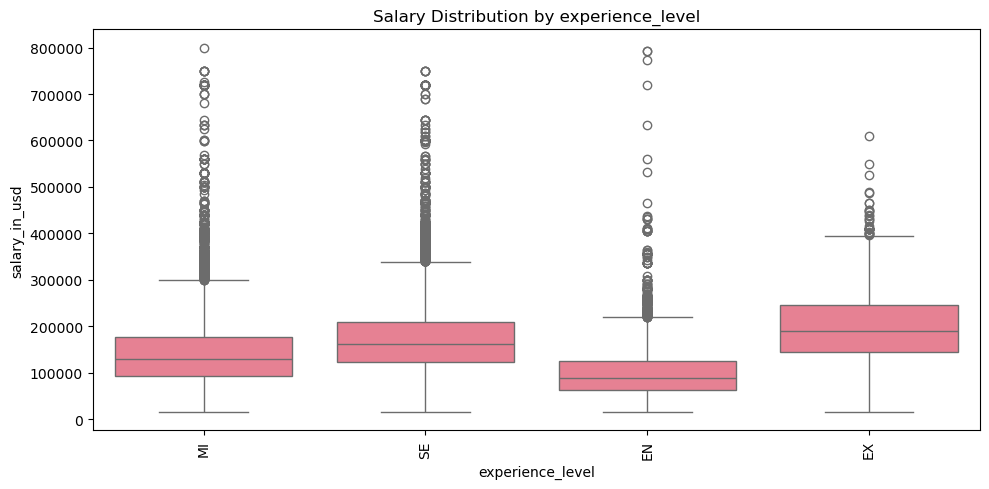

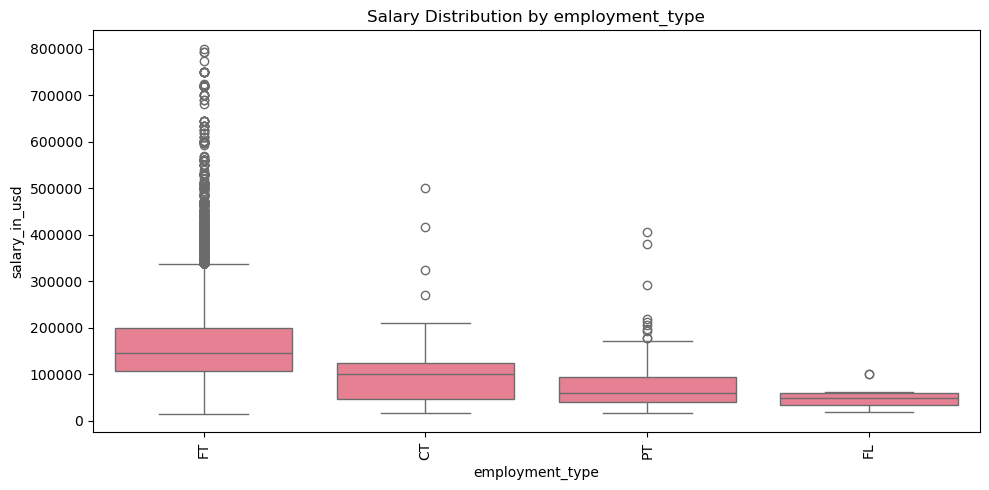

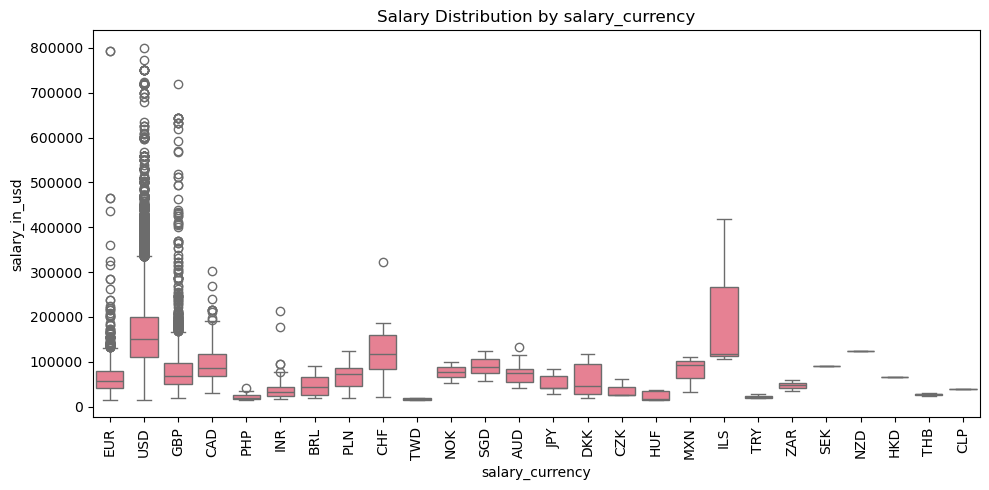

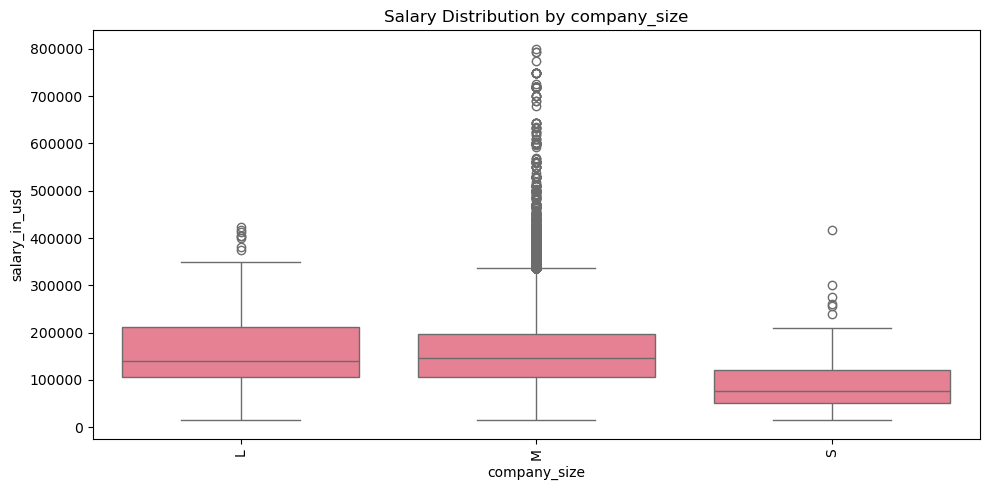

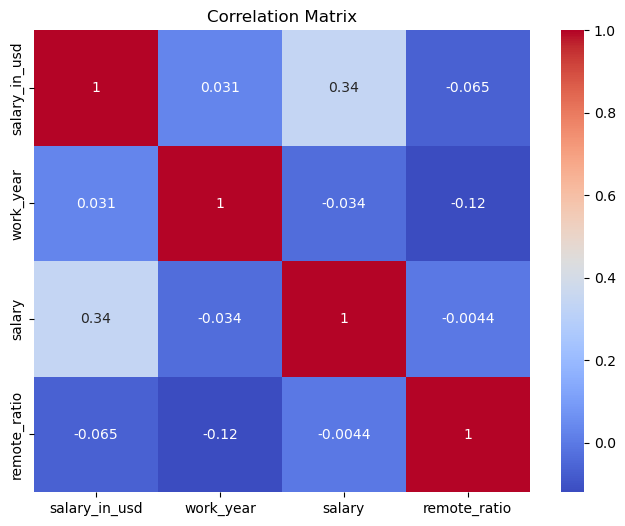

In [18]:
# Exclude specific columns from categorical features
excluded_columns = ['job_title', 'employee_residence', 'company_location']
filtered_categorical_features = [col for col in categorical_features if col not in excluded_columns]

# Categorical features analysis
for col in filtered_categorical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x=col, y='salary_in_usd')
    plt.xticks(rotation=90)
    plt.title(f'Salary Distribution by {col}')
    plt.tight_layout()
    plt.show()

# Correlation analysis for numerical features
numerical_corr = df[['salary_in_usd'] + numerical_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(numerical_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [19]:
# Calculate the total number of outliers per numerical feature
outliers_count = {}

for feature in numerical_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outliers_count[feature] = len(outliers)

# Print the total number of outliers per feature
for feature, count in outliers_count.items():
    print(f"Feature '{feature}' has {count} outliers.")

Feature 'work_year' has 26350 outliers.
Feature 'salary' has 1751 outliers.
Feature 'remote_ratio' has 19004 outliers.


## 4. Hypothesis Testing

In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

# ==== Step 1: Load Data ====
# Define numerical features (exclude categorical)
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('salary_in_usd')  # Remove target variable
target = 'salary_in_usd'

# Select only numerical features
X = df[numerical_features]
y = df[target]

# Normalize numerical features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Add constant (intercept)
X_const = sm.add_constant(X_scaled)

# ==== Step 2: Feature Selection (SelectKBest) ====
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_scaled, y)

# Display feature importance scores
feature_scores = pd.DataFrame({"Feature": X.columns, "Score": selector.scores_})
print("\n🔹 Feature Scores (SelectKBest):")
print(feature_scores.sort_values(by="Score", ascending=False))



🔹 Feature Scores (SelectKBest):
        Feature         Score
1        salary  11677.470613
2  remote_ratio    370.298409
0     work_year     87.476404


In [21]:
# ==== Step 3: Fit OLS Model ====
model = sm.OLS(y, X_const).fit()
residuals = model.resid
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          salary_in_usd   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     4092.
Date:                Mon, 31 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:27:20   Log-Likelihood:            -1.1126e+06
No. Observations:               88584   AIC:                         2.225e+06
Df Residuals:                   88580   BIC:                         2.225e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.576e+05    231.537    680.530   

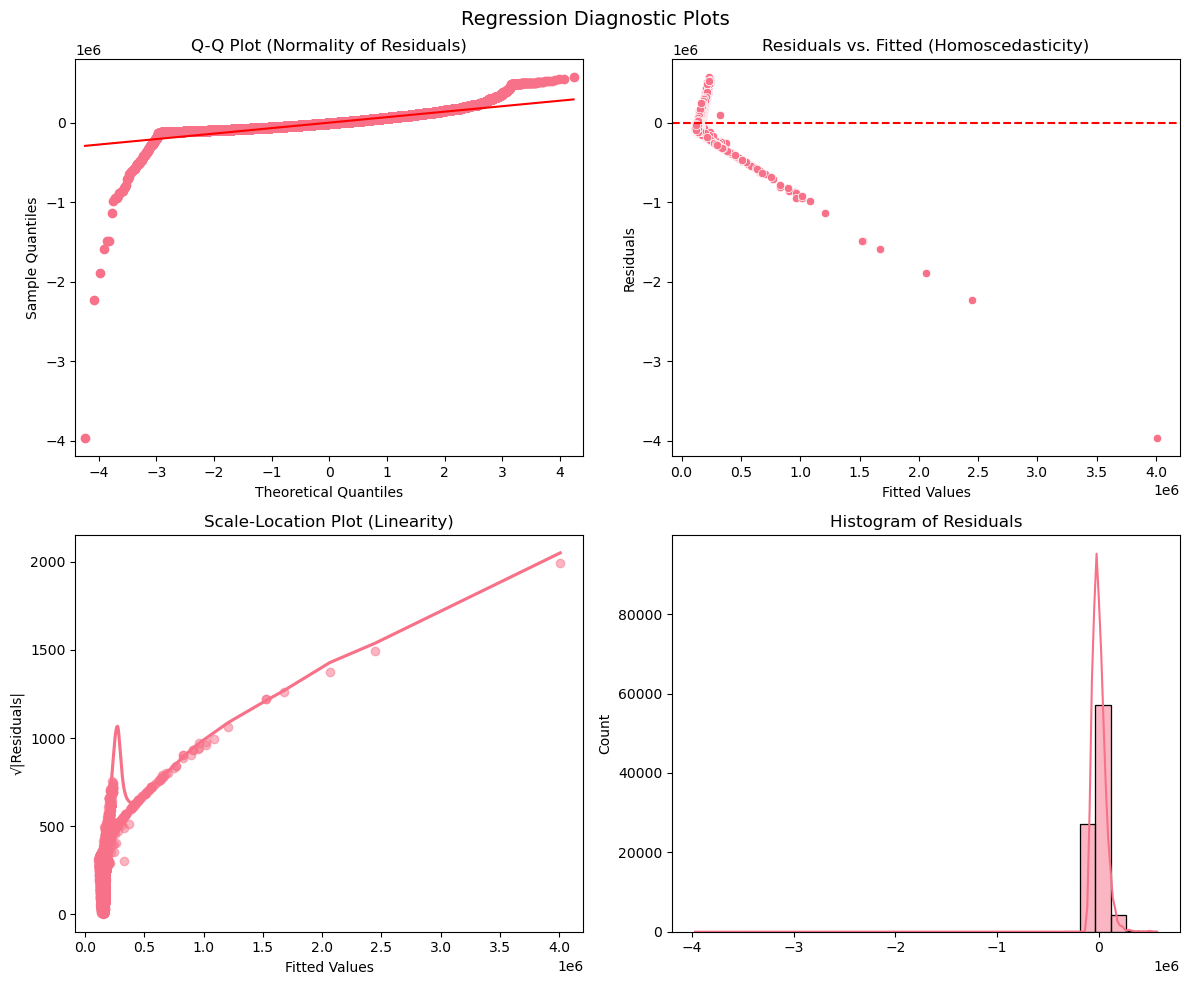

In [22]:
# ==== Step 4: Regression Assumption Checks in a Single Plot ====
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Regression Diagnostic Plots", fontsize=14)

# (1) Q-Q Plot (Normality Check)
sm.qqplot(residuals, line='s', ax=axes[0, 0])
axes[0, 0].set_title("Q-Q Plot (Normality of Residuals)")

# (2) Residuals vs. Fitted Values (Homoscedasticity Check)
sns.scatterplot(x=model.fittedvalues, y=residuals, ax=axes[0, 1])
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel("Fitted Values")
axes[0, 1].set_ylabel("Residuals")
axes[0, 1].set_title("Residuals vs. Fitted (Homoscedasticity)")

# (3) Scale-Location Plot (Linearity Check)
sns.regplot(x=model.fittedvalues, y=np.sqrt(abs(residuals)), lowess=True, scatter_kws={'alpha':0.5}, ax=axes[1, 0])
axes[1, 0].set_xlabel("Fitted Values")
axes[1, 0].set_ylabel("√|Residuals|")
axes[1, 0].set_title("Scale-Location Plot (Linearity)")

# (4) Histogram of Residuals
sns.histplot(residuals, bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Histogram of Residuals")

plt.tight_layout()
plt.show()

In [24]:
# Normality Test (Shapiro-Wilk)
shapiro_test = stats.shapiro(residuals)
print(f"\n🔹 Shapiro-Wilk Test: W={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")

# Homoscedasticity Test (Breusch-Pagan)
bp_test = het_breuschpagan(residuals, X_const)
print(f"\n🔹 Breusch-Pagan Test: p-value={bp_test[1]:.4f} (Heteroscedasticity if p < 0.05)")

# Autocorrelation Test (Durbin-Watson)
dw_stat = durbin_watson(residuals)
print(f"\n🔹 Durbin-Watson Test: {dw_stat:.4f} (Close to 2 indicates no autocorrelation)")


🔹 Shapiro-Wilk Test: W=0.8601, p-value=0.0000

🔹 Breusch-Pagan Test: p-value=0.0000 (Heteroscedasticity if p < 0.05)

🔹 Durbin-Watson Test: 1.6861 (Close to 2 indicates no autocorrelation)


### **Assumption Checks**

#### **a. Normality of Residuals (Shapiro-Wilk Test)**
- **Null Hypothesis (H₀)**: Residuals are normally distributed.
- **Test Result**:
  - **W = 0.8601, p-value = 0.0000**
- **Interpretation**:
  - The p-value is less than 0.05, so we reject the null hypothesis.
  - **Conclusion**: Residuals are not normally distributed.
  - **Recommendation**: Apply transformations to the target variable (e.g., log or square root) or use robust regression techniques.

#### **b. Homoscedasticity (Breusch-Pagan Test)**
- **Null Hypothesis (H₀)**: Residuals have constant variance (homoscedasticity).
- **Test Result**:
  - **p-value = 0.0000**
- **Interpretation**:
  - The p-value is less than 0.05, so we reject the null hypothesis.
  - **Conclusion**: Residuals exhibit heteroscedasticity (non-constant variance).
  - **Recommendation**: Use robust standard errors (e.g., `HC3`) or weighted least squares (WLS).


#### **c. Autocorrelation (Durbin-Watson Test)**
- **Null Hypothesis (H₀)**: Residuals are not autocorrelated.
- **Test Result**:
  - **Durbin-Watson Statistic = 1.6861**
- **Interpretation**:
  - The statistic is close to 2, indicating no strong evidence of autocorrelation.
  - **Conclusion**: The assumption of independence of residuals is likely satisfied.
  - **Recommendation**: No immediate action is required for autocorrelation.


### **4. Recommendations**
Based on the diagnostic tests and model summary:
1. **Address Normality**:
   - Apply transformations to the target variable (e.g., log or square root).
   - Alternatively, use robust regression techniques.
2. **Address Heteroscedasticity**:
   - Use robust standard errors (e.g., `HC3`) or weighted least squares (WLS).
3. **Check Multicollinearity**:
   - If VIF > 10 for any predictor, consider removing or combining highly correlated predictors.
4. **Refine the Model**:
   - Remove non-significant predictors to simplify the model.
   - Consider adding interaction terms or polynomial terms if the relationship between predictors and the target is non-linear.





The model explains a significant portion of the variance in `salary_in_usd` (R-squared = 0.752). However, violations of normality and homoscedasticity assumptions suggest that the model may need refinement. Addressing these issues will improve the reliability and interpretability of the results.

## Applying Transformations

### a. Log Transfromation

Shapiro-Wilk Test: W = 0.9047, p-value = 0.0000
Breusch-Pagan Test: p-value = 0.0000
Durbin-Watson Statistic: 1.5182


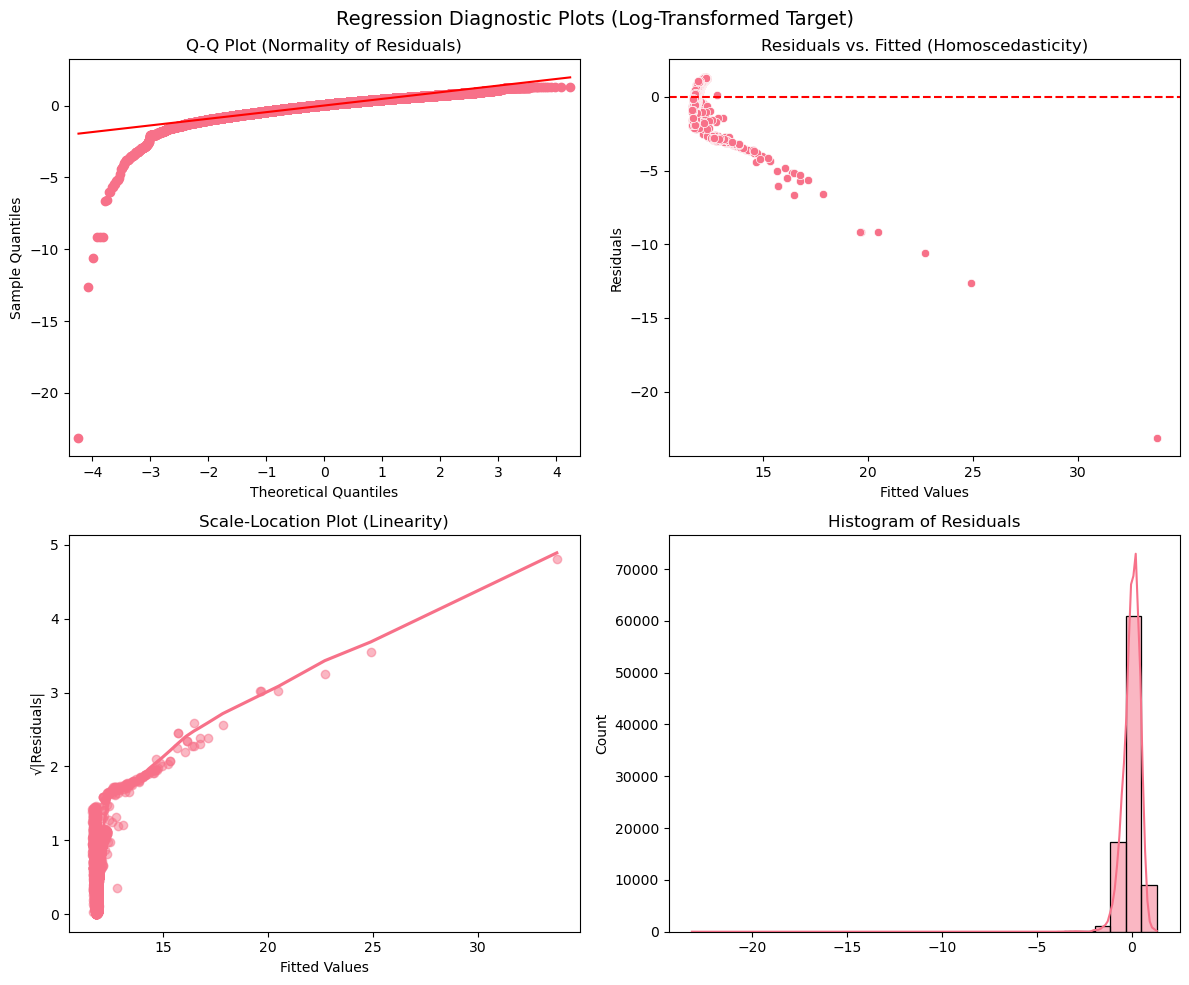

In [25]:
# Apply Log Transformation to the Target Variable
df['log_target'] = np.log(df[target])

# Refit the model with the transformed target
X = sm.add_constant(X)  # Add intercept
model_log = sm.OLS(df['log_target'], X).fit()
residuals_log = model_log.resid

# === Run Diagnostic Tests ===
# Shapiro-Wilk Test for Normality
shapiro_test = stats.shapiro(residuals_log)

# Breusch-Pagan Test for Heteroscedasticity
bp_test = het_breuschpagan(residuals_log, model_log.model.exog)

# Durbin-Watson Test for Autocorrelation
dw_stat = durbin_watson(residuals_log)

# Print Test Results
print("Shapiro-Wilk Test: W = {:.4f}, p-value = {:.4f}".format(shapiro_test[0], shapiro_test[1]))
print("Breusch-Pagan Test: p-value = {:.4f}".format(bp_test[1]))
print("Durbin-Watson Statistic: {:.4f}".format(dw_stat))

# ==== Regression Assumption Checks (Plots) ====
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Regression Diagnostic Plots (Log-Transformed Target)", fontsize=14)

# (1) Q-Q Plot (Normality Check)
sm.qqplot(residuals_log, line='s', ax=axes[0, 0])
axes[0, 0].set_title("Q-Q Plot (Normality of Residuals)")

# (2) Residuals vs. Fitted Values (Homoscedasticity Check)
sns.scatterplot(x=model_log.fittedvalues, y=residuals_log, ax=axes[0, 1])
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel("Fitted Values")
axes[0, 1].set_ylabel("Residuals")
axes[0, 1].set_title("Residuals vs. Fitted (Homoscedasticity)")

# (3) Scale-Location Plot (Linearity Check)
sns.regplot(x=model_log.fittedvalues, y=np.sqrt(abs(residuals_log)), lowess=True, scatter_kws={'alpha':0.5}, ax=axes[1, 0])
axes[1, 0].set_xlabel("Fitted Values")
axes[1, 0].set_ylabel("√|Residuals|")
axes[1, 0].set_title("Scale-Location Plot (Linearity)")

# (4) Histogram of Residuals
sns.histplot(residuals_log, bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Histogram of Residuals")

plt.tight_layout()
plt.show()


### b. Box Cox Transformation

In [ ]:
from scipy.stats import boxcox
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure the target variable is positive
if (df[target] <= 0).any():
    shift_value = abs(df[target].min()) + 1  # Shift to make all values positive
    df['shifted_target'] = df[target] + shift_value
else:
    df['shifted_target'] = df[target]

# Apply Box-Cox transformation
df['boxcox_target'], lambda_value = boxcox(df['shifted_target'])
print(f"Optimal Lambda for Box-Cox Transformation: {lambda_value:.4f}")

# Refit the model with the Box-Cox transformed target
X = sm.add_constant(X)  # Add intercept
model_boxcox = sm.OLS(df['boxcox_target'], X).fit()
residuals_boxcox = model_boxcox.resid

# === Run Diagnostic Tests ===
# Shapiro-Wilk Test for Normality
shapiro_test = shapiro(residuals_boxcox)

# Breusch-Pagan Test for Heteroscedasticity
bp_test = het_breuschpagan(residuals_boxcox, model_boxcox.model.exog)

# Durbin-Watson Test for Autocorrelation
dw_stat = durbin_watson(residuals_boxcox)

# Print Test Results
print("\n=== Diagnostic Test Results (Box-Cox Transformed Target) ===")
print("Shapiro-Wilk Test: W = {:.4f}, p-value = {:.4f}".format(shapiro_test[0], shapiro_test[1]))
print("Breusch-Pagan Test: p-value = {:.4f}".format(bp_test[1]))
print("Durbin-Watson Statistic: {:.4f}".format(dw_stat))

# ==== Regression Assumption Checks (Plots) ====
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Regression Diagnostic Plots (Box-Cox Transformed Target)", fontsize=14)

# (1) Q-Q Plot (Normality Check)
sm.qqplot(residuals_boxcox, line='s', ax=axes[0, 0])
axes[0, 0].set_title("Q-Q Plot (Normality of Residuals)")

# (2) Residuals vs. Fitted Values (Homoscedasticity Check)
sns.scatterplot(x=model_boxcox.fittedvalues, y=residuals_boxcox, ax=axes[0, 1])
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel("Fitted Values")
axes[0, 1].set_ylabel("Residuals")
axes[0, 1].set_title("Residuals vs. Fitted (Homoscedasticity)")

# (3) Scale-Location Plot (Linearity Check)
sns.regplot(x=model_boxcox.fittedvalues, y=np.sqrt(abs(residuals_boxcox)), lowess=True, scatter_kws={'alpha':0.5}, ax=axes[1, 0])
axes[1, 0].set_xlabel("Fitted Values")
axes[1, 0].set_ylabel("√|Residuals|")
axes[1, 0].set_title("Scale-Location Plot (Linearity)")

# (4) Histogram of Residuals
sns.histplot(residuals_boxcox, bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Histogram of Residuals")

plt.tight_layout()
plt.show()

Optimal Lambda for Box-Cox Transformation: 0.3064

=== Diagnostic Test Results (Box-Cox Transformed Target) ===
Shapiro-Wilk Test: W = 0.9205, p-value = 0.0000
Breusch-Pagan Test: p-value = 0.0000
Durbin-Watson Statistic: 1.5725


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import boxcox

# Load dataset (Replace df with your actual dataset)
# Ensure target variable is positive for Box-Cox transformation
df['target'] = df['target'] + 1e-5 if df['target'].min() <= 0 else df['target']

# Apply Box-Cox transformation to the target variable
df['target_transformed'], lambda_value = boxcox(df['target'])
print(f"Optimal Lambda for Box-Cox: {lambda_value}")

# Define predictor variables and target
X = df.drop(columns=['target', 'target_transformed'])  # Drop original target
y = df['target_transformed']
X_const = sm.add_constant(X)

# Fit OLS Model
model = sm.OLS(y, X_const).fit()
residuals = model.resid

# ---- Rerun Diagnostic Tests ----
# Normality Check (Shapiro-Wilk Test)
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test: W={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

# Homoscedasticity Check (Breusch-Pagan Test)
bp_test = het_breuschpagan(residuals, X_const)
print(f"Breusch-Pagan Test: p-value={bp_test[1]}")

# Autocorrelation Check (Durbin-Watson Test)
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat}")

# ---- Diagnostic Plots ----
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Regression Diagnostic Plots (Box-Cox Transformed)", fontsize=14)

# (1) Q-Q Plot
sm.qqplot(residuals, line='s', ax=axes[0, 0])
axes[0, 0].set_title("Q-Q Plot (Normality of Residuals)")

# (2) Residuals vs. Fitted Values
sns.scatterplot(x=model.fittedvalues, y=residuals, ax=axes[0, 1])
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_title("Residuals vs. Fitted (Homoscedasticity)")

# (3) Scale-Location Plot
sns.regplot(x=model.fittedvalues, y=np.sqrt(abs(residuals)), lowess=True, scatter_kws={'alpha':0.5}, ax=axes[1, 0])
axes[1, 0].set_title("Scale-Location Plot (Linearity)")

# (4) Histogram of Residuals
sns.histplot(residuals, bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Histogram of Residuals")

plt.tight_layout()
plt.show()


## 5. Model Development

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Ensure y is properly defined
y = df['salary_in_usd']

# Simple Linear Regression
simple_model = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for scaling
    ('regressor', LinearRegression())
])

# Fit simple model with work_year as predictor
X_simple = df[['work_year']]  # Ensure X_simple is a DataFrame
simple_model.fit(X_simple, y)
y_pred_simple = simple_model.predict(X_simple)

print('Simple Linear Regression Results:')
print(f'R² Score: {r2_score(y, y_pred_simple):.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y, y_pred_simple)):.4f}')

# Multiple Linear Regression
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Use the preprocessor defined earlier
    ('regressor', LinearRegression())
])

# Fit full model
full_pipeline.fit(X_train, y_train)
y_pred = full_pipeline.predict(X_test)

print('\nMultiple Linear Regression Results:')
print(f'R² Score: {r2_score(y_test, y_pred):.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}')

Best parameters: {'regressor__alpha': 1.0}
Best cross-validation score: 54858.5555024256
Test set R² score: -0.2936
Test set RMSE: 84525.1478


In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Ensure y is properly defined
y = df['salary_in_usd']

# Simple Linear Regression
simple_model = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for scaling
    ('regressor', LinearRegression())
])

# Fit simple model with work_year as predictor
X_simple = df[['work_year']]  # Ensure X_simple is a DataFrame
simple_model.fit(X_simple, y)
y_pred_simple = simple_model.predict(X_simple)

print('Simple Linear Regression Results:')
print(f'R² Score: {r2_score(y, y_pred_simple):.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y, y_pred_simple)):.4f}')

# Multiple Linear Regression (using only numerical features)
from sklearn.compose import ColumnTransformer

# Preprocessor for numerical features only
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ])

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Use only numerical features
    ('regressor', LinearRegression())
])

# Fit full model
full_pipeline.fit(X_train[numerical_features], y_train)  # Use only numerical features
y_pred = full_pipeline.predict(X_test[numerical_features])  # Use only numerical features

print('\nMultiple Linear Regression Results:')
print(f'R² Score: {r2_score(y_test, y_pred):.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}')

Simple Linear Regression Results:
R² Score: 0.0010
RMSE: 73494.6784

Multiple Linear Regression Results:
R² Score: -0.0169
RMSE: 74942.5364


In [40]:
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Ensure y is properly defined
y = df['salary_in_usd']

# Simple Linear Regression
simple_model = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for scaling
    ('regressor', LinearRegression())
])

# Fit simple model with work_year as predictor
X_simple = df[['remote_ratio']]  # Ensure X_simple is a DataFrame
simple_model.fit(X_simple, y)
y_pred_simple = simple_model.predict(X_simple)

print('Simple Linear Regression Results:')
print(f'R² Score: {r2_score(y, y_pred_simple):.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y, y_pred_simple)):.4f}')

# Multiple Linear Regression (using only numerical features)
from sklearn.compose import ColumnTransformer

# Preprocessor for numerical features only
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ])

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Use only numerical features
    ('regressor', LinearRegression())
])

# Fit full model
full_pipeline.fit(X_train[numerical_features], y_train)  # Use only numerical features
y_pred = full_pipeline.predict(X_test[numerical_features])  # Use only numerical features

print('\nMultiple Linear Regression Results:')
print(f'R² Score: {r2_score(y_test, y_pred):.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}')

Simple Linear Regression Results:
R² Score: 0.0042
RMSE: 73377.7480

Multiple Linear Regression Results:
R² Score: -0.0169
RMSE: 74942.5364


## 6. Model Optimization

In [ ]:
# Create pipeline with regularization options
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Parameter grid for hyperparameter tuning
param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)
print('Best cross-validation score:', np.sqrt(-grid_search.best_score_))

# Predict with best model
y_pred_best = grid_search.predict(X_test)
print(f'Test set R² score: {r2_score(y_test, y_pred_best):.4f}')
print(f'Test set RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f}')

## 7. Model Diagnostics

In [ ]:
# Residual analysis
residuals = y_test - y_pred_best

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.scatter(y_pred_best, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.subplot(122)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

# Homoscedasticity test
_, p_value = stats.levene(y_test, y_pred_best)
print(f'Levene test p-value: {p_value:.4f}')

## 8. Feature Importance Analysis

In [ ]:
# Get feature names after preprocessing
feature_names = (numerical_features + 
                [f"{feat}_{val}" for feat, vals in 
                 zip(categorical_features, 
                     grid_search.best_estimator_.named_steps['preprocessor']
                     .named_transformers_['cat'].named_steps['onehot'].categories_)
                 for val in vals[1:]])

# Get coefficients from best model
coefficients = grid_search.best_estimator_.named_steps['regressor'].coef_

# Plot feature importance
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('importance', ascending=True)

plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()